In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=1222afd67605bf75e7f0b76d578cfcb4f1fe299d7c1917fc72ba9b00d54bdec0
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
import numpy as np
import pandas as pd
import os
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.sql.functions import col, sum


In [3]:
spark = SparkSession.builder.appName('AIRLINES ANALYSIS').getOrCreate()

In [4]:
flights_df = spark.read.csv('/content/flights-larger.csv',header=True,inferSchema=True,nullValue='NA')

In [5]:
print("The data contain records." ,flights_df.count())

flights_df.show()

The data contain records. 275000
+---+---+---+-------+------+---+----+------+--------+-----+
|mon|dom|dow|carrier|flight|org|mile|depart|duration|delay|
+---+---+---+-------+------+---+----+------+--------+-----+
| 10| 10|  1|     OO|  5836|ORD| 157|  8.18|      51|   27|
|  1|  4|  1|     OO|  5866|ORD| 466|  15.5|     102| NULL|
| 11| 22|  1|     OO|  6016|ORD| 738|  7.17|     127|  -19|
|  2| 14|  5|     B6|   199|JFK|2248| 21.17|     365|   60|
|  5| 25|  3|     WN|  1675|SJC| 386| 12.92|      85|   22|
|  3| 28|  1|     B6|   377|LGA|1076| 13.33|     182|   70|
|  5| 28|  6|     B6|   904|ORD| 740|  9.58|     130|   47|
|  1| 19|  2|     UA|   820|SFO| 679| 12.75|     123|  135|
|  8|  5|  5|     US|  2175|LGA| 214|  13.0|      71|  -10|
|  5| 27|  5|     AA|  1240|ORD|1197| 14.42|     195|  -11|
|  8| 20|  6|     B6|   119|JFK|1182| 14.67|     198|   20|
|  2|  3|  1|     AA|  1881|JFK|1090| 15.92|     200|   -9|
|  8| 26|  5|     B6|    35|JFK|1028| 20.58|     193|  102|
|  4|  

In [6]:
# Count the number of null values in each column
flights_df = flights_df.replace("NA", None)
null_counts = flights_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in flights_df.columns])

In [7]:
# Show the counts
null_counts.show()

+---+---+---+-------+------+---+----+------+--------+-----+
|mon|dom|dow|carrier|flight|org|mile|depart|duration|delay|
+---+---+---+-------+------+---+----+------+--------+-----+
|  0|  0|  0|      0|     0|  0|   0|     0|       0|16711|
+---+---+---+-------+------+---+----+------+--------+-----+



In [8]:
print(flights_df.dtypes)
flights_df.printSchema()

[('mon', 'int'), ('dom', 'int'), ('dow', 'int'), ('carrier', 'string'), ('flight', 'int'), ('org', 'string'), ('mile', 'int'), ('depart', 'double'), ('duration', 'int'), ('delay', 'int')]
root
 |-- mon: integer (nullable = true)
 |-- dom: integer (nullable = true)
 |-- dow: integer (nullable = true)
 |-- carrier: string (nullable = true)
 |-- flight: integer (nullable = true)
 |-- org: string (nullable = true)
 |-- mile: integer (nullable = true)
 |-- depart: double (nullable = true)
 |-- duration: integer (nullable = true)
 |-- delay: integer (nullable = true)



IMPUTING & DROPPING NULL VALUES

In [9]:
from pyspark.sql.functions import mean
# Calculate mean values for 'mile' and 'delay' columns
mean_mile = flights_df.select(mean("mile")).collect()[0][0]
mean_delay = flights_df.select(mean("delay")).collect()[0][0]

In [10]:
# Fill null values in 'mile' and 'delay' columns with their means
flights_df = flights_df.na.fill(mean_mile, subset=["mile"])
flights_df = flights_df.na.fill(mean_delay, subset=["delay"])

In [11]:
flights_df = flights_df.dropna()
print(flights_df.count())

275000


In [12]:
from pyspark.sql.functions import round, when, col

# Create a new column 'km' for distance in kilometers
flights_km = flights_df.withColumn('km', round(flights_df['mile'] * 1.60934, 0))

flights_km = flights_km.withColumn('label', (flights_km['delay'] >= 15).cast('integer'))

flights_km.show()

+---+---+---+-------+------+---+----+------+--------+-----+------+-----+
|mon|dom|dow|carrier|flight|org|mile|depart|duration|delay|    km|label|
+---+---+---+-------+------+---+----+------+--------+-----+------+-----+
| 10| 10|  1|     OO|  5836|ORD| 157|  8.18|      51|   27| 253.0|    1|
|  1|  4|  1|     OO|  5866|ORD| 466|  15.5|     102|   28| 750.0|    1|
| 11| 22|  1|     OO|  6016|ORD| 738|  7.17|     127|  -19|1188.0|    0|
|  2| 14|  5|     B6|   199|JFK|2248| 21.17|     365|   60|3618.0|    1|
|  5| 25|  3|     WN|  1675|SJC| 386| 12.92|      85|   22| 621.0|    1|
|  3| 28|  1|     B6|   377|LGA|1076| 13.33|     182|   70|1732.0|    1|
|  5| 28|  6|     B6|   904|ORD| 740|  9.58|     130|   47|1191.0|    1|
|  1| 19|  2|     UA|   820|SFO| 679| 12.75|     123|  135|1093.0|    1|
|  8|  5|  5|     US|  2175|LGA| 214|  13.0|      71|  -10| 344.0|    0|
|  5| 27|  5|     AA|  1240|ORD|1197| 14.42|     195|  -11|1926.0|    0|
|  8| 20|  6|     B6|   119|JFK|1182| 14.67|     19

In [13]:
# Group the data by the 'label' column and count the number of instances for each class
class_counts = flights_km.groupBy("label").count()

# Show the class counts
class_counts.show()


+-----+------+
|label| count|
+-----+------+
|    1|147299|
|    0|127701|
+-----+------+



PREPROCESSING

2.STRING INDEXER

In [14]:
from pyspark.ml.feature import StringIndexer
# Create an indexer, which identifies categories and then creates a new column with numeric index values
carrier_indexer = StringIndexer(inputCol='carrier', outputCol='carrier_idx')

# Repeat the process for org column
org_indexer = StringIndexer(inputCol='org', outputCol='org_idx')


PREPROCESSING

2.VECTOR ASSEMBLER

In [15]:
from pyspark.ml.feature import VectorAssembler
# Create an assembler object
assembler = VectorAssembler(inputCols=['mon', 'dom', 'dow',
'carrier_idx', 'org_idx', 'km', 'depart', 'duration'], outputCol='features')


In [16]:
flights_train, flights_test = flights_km.randomSplit([0.8, 0.2], seed=42)

DECISION TREE CLASSIFIER

In [17]:
from pyspark.ml.classification import DecisionTreeClassifier


In [18]:
from pyspark.ml import Pipeline
# Create a Decision Tree classifier
dt = DecisionTreeClassifier(labelCol='label', featuresCol='features')
# stages =[,assembler,dt]

stages = [carrier_indexer, org_indexer, assembler, dt]

# Create the pipeline
pipeline = Pipeline(stages=stages)

# Fit and evaluate the pipeline
pipeline_model = pipeline.fit(flights_train)
predictions = pipeline_model.transform(flights_test)



In [19]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

# Calculate the accuracy
dt_accuracy = evaluator.evaluate(predictions)

print(f"Accuracy: {dt_accuracy}")


Accuracy: 0.6419900930814871


LOGISTIC REGRESSION


In [20]:
from pyspark.ml.classification import LogisticRegression

# Create a Logistic Regression classifier
logistic_regression = LogisticRegression(labelCol='label', featuresCol='features')

# Define the stages for the pipeline
stages = [carrier_indexer, org_indexer, assembler, logistic_regression]

# Create the pipeline
pipeline = Pipeline(stages=stages)

# Fit and evaluate the pipeline
pipeline_model = pipeline.fit(flights_train)
predictions = pipeline_model.transform(flights_test)

# Create the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

# Calculate the accuracy
lr_accuracy = evaluator.evaluate(predictions)

print(f"Accuracy for Logistic Regression: {lr_accuracy}")


Accuracy for Logistic Regression: 0.6137209006949359


RANDOM FOREST ALGORITHM

In [21]:
from decimal import ROUND_HALF_EVEN
from pyspark.ml.classification import RandomForestClassifier

# Create a Random Forest classifier
random_forest = RandomForestClassifier(labelCol='label', featuresCol='features')

# Define the stages for the pipeline
stages = [carrier_indexer, org_indexer, assembler, random_forest]

# Create the pipeline
pipeline = Pipeline(stages=stages)

# Fit and evaluate the pipeline
pipeline_model = pipeline.fit(flights_train)
predictions = pipeline_model.transform(flights_test)

# Create the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

# Calculate the accuracy
rf_accuracy = evaluator.evaluate(predictions)

print(f"Accuracy for Random Forest: {rf_accuracy}")


Accuracy for Random Forest: 0.6379257162556928


NAIVE BAYES ALGORITHM

In [22]:
from pyspark.ml.classification import NaiveBayes

# Create a Naive Bayes classifier
nb = NaiveBayes(labelCol='label', featuresCol='features')

# Define the pipeline stages
stages = [carrier_indexer,org_indexer,assembler, nb]

# Create the pipeline
pipeline = Pipeline(stages=stages)

# Fit and evaluate the pipeline
pipeline_model = pipeline.fit(flights_train)
predictions = pipeline_model.transform(flights_test)
# Create the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

# Calculate the accuracy
nb_accuracy = evaluator.evaluate(predictions)

print(f"Accuracy for Random Forest: {nb_accuracy}")


Accuracy for Random Forest: 0.5593417161105365


GBT CLASSIFIER

In [23]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline

# Create a Gradient Boosting Classifier
gbt = GBTClassifier(labelCol='label', featuresCol='features')

# Define the pipeline stages
stages = [carrier_indexer,org_indexer,assembler, nb]

# Create the pipeline
pipeline = Pipeline(stages=stages)

# Fit and evaluate the pipeline
pipeline_model = pipeline.fit(flights_train)
predictions = pipeline_model.transform(flights_test)
# Create the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

# Calculate the accuracy
gbt_accuracy = evaluator.evaluate(predictions)

print(f"Accuracy for Random Forest: {gbt_accuracy}")

Accuracy for Random Forest: 0.5593417161105365


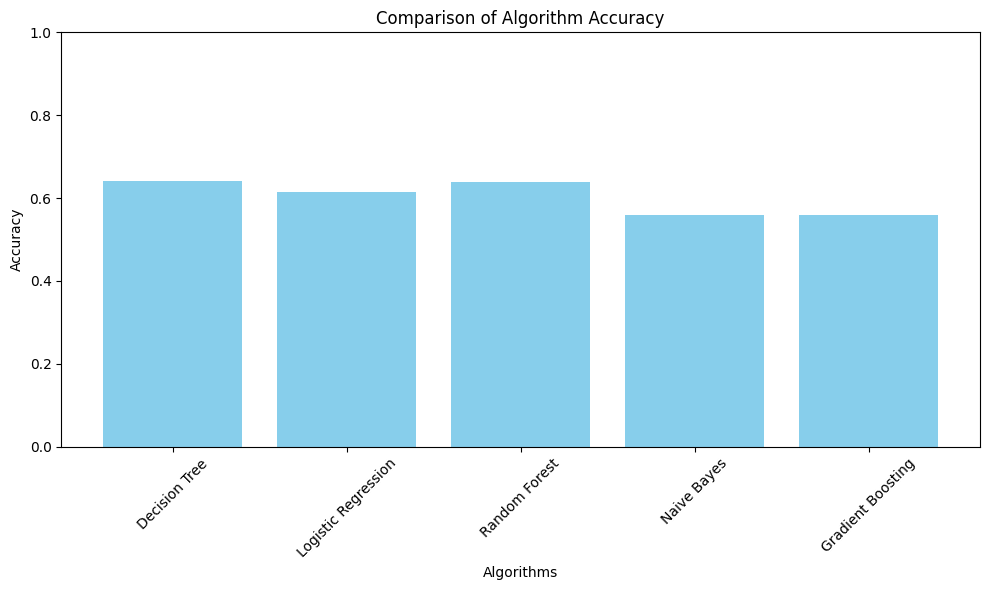

In [24]:
import matplotlib.pyplot as plt

# List of algorithm names and their corresponding accuracy values
algorithm_names = ["Decision Tree", "Logistic Regression", "Random Forest", "Naive Bayes", "Gradient Boosting",]
accuracy_values = [dt_accuracy,lr_accuracy,rf_accuracy,nb_accuracy,gbt_accuracy]  # Replace with actual accuracy values

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(algorithm_names, accuracy_values, color='skyblue')
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.title('Comparison of Algorithm Accuracy')
plt.ylim(0.0, 1.0)  # Set the y-axis range (0 to 1)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Display the chart
plt.tight_layout()
plt.show()


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Define the parameter grid to search
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [16, 32, 64]) \
    .build()

# Set up a cross-validator
crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,  # Use the evaluator appropriate for your problem
    numFolds=5  # Number of cross-validation folds
)

# Perform the cross-validation to find the best model
cv_model = crossval.fit(flights_train)


In [ ]:
# Use the best model from cross-validation
best_model = cv_model.bestModel

# Make predictions on the test data
test_predictions = best_model.transform(flights_test)

# Evaluate the model using the appropriate evaluator
evaluation_result = evaluator.evaluate(test_predictions, {evaluator.metricName: "accuracy"})
print(f"Accuracy: {evaluation_result}")

# You can also extract the best hyperparameters like maxDepth and maxBins
#best_max_depth = best_model.stages[-1].getOrDefault("maxDepth")
#best_max_bins = best_model.stages[-1].getOrDefault("maxBins")

# print(f"Best Max Depth: {best_max_depth}")
# print(f"Best Max Bins: {best_max_bins}")